<a href="https://colab.research.google.com/github/yjodev/Tobigs19/blob/main/%5Byujin%5D_%EA%B2%B0%EC%B8%A1%EC%B9%98_%EC%B2%98%EB%A6%AC%EC%99%80_meta_psudo_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import pandas as pd # data manipulation
import numpy as np # numerical operations
import random # setting a seed for reproducibility
import os # setting a seed for reproducibility
import gc # garbage collection

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder # for converting categorical variables to numerical variables.


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import seaborn as sns

import torch
from torch import nn, Tensor
import torch.optim as optim
import torch.nn.functional as F

from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# to set the seed for reproducibility.
def seed_everything(seed): 
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

# csv to parquet
메모리에 효율적인 데이터 유형을 사용하여 용량을 줄이고 빠른 작업이 가능합니다

In [ ]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')
#  to convert the input csv files into the more memory-efficient parquet format. 
# The function reads in a csv file and saves it as a parquet file with the given save_name. 
# The function then deletes the dataframe and runs garbage collection to free up memory.

In [ ]:
root_path = '/content/drive/MyDrive/flight project'
train_df = pd.read_csv(root_path + '/train.csv')

In [ ]:
csv_to_parquet(root_path + '/train.csv', 'train')
csv_to_parquet(root_path + '/test.csv', 'test')

train Done.
test Done.


# Data Load

In [ ]:
#loaded into dataframes
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
sample_submission = pd.read_csv(root_path + '/sample_submission.csv', index_col = 0)

In [ ]:
train.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,None
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,None


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

In [ ]:
train.isna().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                109015
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           109079
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64

In [ ]:
train['Delay'].value_counts(normalize=True) # labeled 된 데이터도 편향됨

Not_Delayed    0.82353
Delayed        0.17647
Name: Delay, dtype: float64

## 결측치 처리 
- mode 말고 더 나은 방법은 없을까?

### 1. State 결측치는 Airport-State dictionary를 이용하여 채우기

In [ ]:
# Create a subset of the original data with only the relevant columns
airports = train[['Origin_Airport', 'Origin_State']].drop_duplicates()

In [ ]:
airports.head()

,Origin_Airport,Origin_State
0,OKC,Oklahoma
1,ORD,Illinois
2,CLT,North Carolina
3,LAX,California
4,SFO,California


In [ ]:
airports.isna().sum()

Origin_Airport      0
Origin_State      373
dtype: int64

In [ ]:
airports.dropna(inplace=True)

In [ ]:
airports.isna().sum()

Origin_Airport    0
Origin_State      0
dtype: int64

In [ ]:
# Create a dictionary mapping airports to their respective states
airport_states = {k: v for k, v in zip(airports['Origin_Airport'], airports['Origin_State']) if v is not None}

In [ ]:
airport_states

{'OKC': 'Oklahoma',
 'ORD': 'Illinois',
 'CLT': 'North Carolina',
 'LAX': 'California',
 'SFO': 'California',
 'EWR': 'New Jersey',
 'LIT': 'Arkansas',
 'DCA': 'Virginia',
 'PHL': 'Pennsylvania',
 'CLE': 'Ohio',
 'MAF': 'Texas',
 'PHX': 'Arizona',
 'PIT': 'Pennsylvania',
 'BDL': 'Connecticut',
 'BWI': 'Maryland',
 'OAK': 'California',
 'BUF': 'New York',
 'TPA': 'Florida',
 'SAN': 'California',
 'SEA': 'Washington',
 'SLC': 'Utah',
 'IAH': 'Texas',
 'ABQ': 'New Mexico',
 'COS': 'Colorado',
 'PDX': 'Oregon',
 'ATL': 'Georgia',
 'MCI': 'Missouri',
 'MEM': 'Tennessee',
 'DAL': 'Texas',
 'RDU': 'North Carolina',
 'HOU': 'Texas',
 'RIC': 'Virginia',
 'IAD': 'Virginia',
 'OAJ': 'North Carolina',
 'JFK': 'New York',
 'ANC': 'Alaska',
 'RST': 'Minnesota',
 'LGA': 'New York',
 'ISP': 'New York',
 'BGR': 'Maine',
 'OMA': 'Nebraska',
 'ROC': 'New York',
 'CMH': 'Ohio',
 'OGG': 'Hawaii',
 'LAS': 'Nevada',
 'ORF': 'Virginia',
 'DAB': 'Florida',
 'DEN': 'Colorado',
 'HRL': 'Texas',
 'MGM': 'Alabama'

In [ ]:
# Fill in missing 'Origin_State' values based on the corresponding airport
train['Origin_State'] = train.apply(lambda row: airport_states.get(row['Origin_Airport'], row['Origin_State']), axis=1)

# Fill in missing 'Destination_State' values based on the corresponding airport
train['Destination_State'] = train.apply(lambda row: airport_states.get(row['Destination_Airport'], row['Destination_State']), axis=1)

# Check if there are any remaining missing values
train.isna().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                     0
Destination_Airport              0
Destination_Airport_ID           0
Destination_State                1
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64

잘되었다 . . (아마도)

### 2. Departure Time 어떻게 채우지?
- Departure Time -  Arrivial Time 
- Distance                         
        

In [ ]:
# Create a subset of the original data with only the relevant columns
times = train[['Estimated_Departure_Time', 'Estimated_Arrival_Time','Distance','Origin_Airport','Destination_Airport','Airline']].drop_duplicates()
times.head()

,Estimated_Departure_Time,Estimated_Arrival_Time,Distance,Origin_Airport,Destination_Airport,Airline
0,NaN,NaN,419.0,OKC,HOU,Southwest Airlines Co.
1,740.0,1024.0,1250.0,ORD,SLC,SkyWest Airlines Inc.
2,1610.0,1805.0,544.0,CLT,LGA,American Airlines Inc.
3,905.0,1735.0,2454.0,LAX,EWR,United Air Lines Inc.
4,900.0,1019.0,250.0,SFO,ACV,SkyWest Airlines Inc.


In [ ]:
times['Departure_Arrival_Diff'] = times['Estimated_Arrival_Time'] - times['Estimated_Departure_Time']
times.head()

,Estimated_Departure_Time,Estimated_Arrival_Time,Distance,Origin_Airport,Destination_Airport,Airline,Departure_Arrival_Diff
0,NaN,NaN,419.0,OKC,HOU,Southwest Airlines Co.,NaN
1,740.0,1024.0,1250.0,ORD,SLC,SkyWest Airlines Inc.,284.0
2,1610.0,1805.0,544.0,CLT,LGA,American Airlines Inc.,195.0
3,905.0,1735.0,2454.0,LAX,EWR,United Air Lines Inc.,830.0
4,900.0,1019.0,250.0,SFO,ACV,SkyWest Airlines Inc.,119.0


In [ ]:
times.dropna(inplace=True)

In [ ]:
times.head()

,Estimated_Departure_Time,Estimated_Arrival_Time,Distance,Origin_Airport,Destination_Airport,Airline,Departure_Arrival_Diff
1,740.0,1024.0,1250.0,ORD,SLC,SkyWest Airlines Inc.,284.0
2,1610.0,1805.0,544.0,CLT,LGA,American Airlines Inc.,195.0
3,905.0,1735.0,2454.0,LAX,EWR,United Air Lines Inc.,830.0
4,900.0,1019.0,250.0,SFO,ACV,SkyWest Airlines Inc.,119.0
6,1742.0,1903.0,200.0,EWR,BOS,United Air Lines Inc.,161.0


In [ ]:
from sklearn.linear_model import LinearRegression

# Create a linear regression object
regressor = LinearRegression()

# Extract the data for the regression
X = times['Distance'].values.reshape(-1, 1) # Independent variable
y = times['Departure_Arrival_Diff'].values.reshape(-1, 1) # Dependent variable

# Train the model
regressor.fit(X, y)

# Print the coefficients
print('Intercept: ', regressor.intercept_)
print('Coefficient: ', regressor.coef_)


Intercept:  [136.76721206]
Coefficient:  [[0.02429745]]


* 회귀분석결과
  - Y(운행시간)
  - X(거리)
  - Y = 136.76 X  0.02


In [ ]:
missing_arrival = train[train['Estimated_Arrival_Time'].isna()]
missing_arrival.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None
5,TRAIN_000005,4,13,1545.0,NaN,0,0,EWR,11618,New Jersey,DCA,11278,Virginia,199.0,Republic Airlines,UA,20452.0,N657RW,Not_Delayed
20,TRAIN_000020,7,2,620.0,NaN,0,0,BWI,10821,Maryland,BOS,10721,Massachusetts,369.0,Southwest Airlines Co.,WN,19393.0,N292WN,None
24,TRAIN_000024,11,28,1030.0,NaN,0,0,TPA,15304,Florida,BHM,10599,Alabama,459.0,Southwest Airlines Co.,WN,19393.0,N921WN,None
28,TRAIN_000028,8,7,930.0,NaN,0,0,SAN,14679,California,LAS,12889,Nevada,258.0,Spirit Air Lines,NK,20416.0,N628NK,Not_Delayed


In [ ]:
missing_arrival = missing_arrival.dropna(subset=['Estimated_Departure_Time'])
missing_arrival.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
5,TRAIN_000005,4,13,1545.0,NaN,0,0,EWR,11618,New Jersey,DCA,11278,Virginia,199.0,Republic Airlines,UA,20452.0,N657RW,Not_Delayed
20,TRAIN_000020,7,2,620.0,NaN,0,0,BWI,10821,Maryland,BOS,10721,Massachusetts,369.0,Southwest Airlines Co.,WN,19393.0,N292WN,None
24,TRAIN_000024,11,28,1030.0,NaN,0,0,TPA,15304,Florida,BHM,10599,Alabama,459.0,Southwest Airlines Co.,WN,19393.0,N921WN,None
28,TRAIN_000028,8,7,930.0,NaN,0,0,SAN,14679,California,LAS,12889,Nevada,258.0,Spirit Air Lines,NK,20416.0,N628NK,Not_Delayed
29,TRAIN_000029,10,20,800.0,NaN,0,0,SEA,14747,Washington,ANC,10299,Alaska,1448.0,Alaska Airlines Inc.,AS,19930.0,N457AS,None


In [ ]:
train['Departure_Arrival_Diff'] = train['Estimated_Arrival_Time'] - train['Estimated_Departure_Time']
train.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Departure_Arrival_Diff
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None,NaN
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None,284.0
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None,195.0
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,None,830.0
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,None,119.0


In [ ]:
# 1. Create a new dataframe with missing values
missing_df = train[train['Departure_Arrival_Diff'].isna() & train['Distance'].notna()]

# 2. Use the trained model to predict missing values
predicted_values = regressor.predict(missing_df[['Distance']])

# 3. Assign predicted values to the original dataframe
train.loc[missing_df.index, 'Departure_Arrival_Diff'] = predicted_values


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [ ]:
train.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Departure_Arrival_Diff
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None,146.947843
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None,284.000000
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None,195.000000
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,None,830.000000
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,None,119.000000


In [ ]:
train['Estimated_Arrival_Time'] = train['Estimated_Arrival_Time'].fillna(train['Estimated_Departure_Time'] + train['Departure_Arrival_Diff'])
train['Estimated_Departure_Time'] = train['Estimated_Departure_Time'].fillna(train['Estimated_Arrival_Time'] - train['Departure_Arrival_Diff'])

train.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Departure_Arrival_Diff
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None,146.947843
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None,284.000000
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None,195.000000
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,None,830.000000
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,None,119.000000


In [ ]:
train.isna().sum() # Arrival & Departure Time 결측치 채움. 
# 안채워진 11688개는 Departure_Time, Arrival_Time 둘 다 missing인듯 -> 이건 그냥 mode로 채우기

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time     11688
Estimated_Arrival_Time       11688
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                     0
Destination_Airport              0
Destination_Airport_ID           0
Destination_State                1
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
Departure_Arrival_Diff           0
dtype: int64

### 3. Carrier_Code(IATA) 와 Carrier_ID(DOT)는 서로 unique함을 확인함
-> 두 값을 이용해서 채우기

In [ ]:
unique_carrier_codes = train['Carrier_Code(IATA)'].unique()
unique_carrier_codes 

array(['WN', 'UA', 'AA', 'DL', None, 'AS', 'B6', 'NK', 'F9', 'HA', 'G4',
       'VX'], dtype=object)

In [ ]:
unique_carrier_IDs = train['Carrier_ID(DOT)'].unique()
unique_carrier_IDs 

array([19393., 20304., 19805.,    nan, 20452., 20366., 19790., 20046.,
       19687., 20409., 20416., 19930., 19977., 20378., 20436., 20237.,
       20397., 20363., 20427., 20398., 19690., 20368., 21171., 20225.,
       21167., 20500., 20445., 20263., 20253.])

In [ ]:
unique_carrier_pairs = train[['Carrier_Code(IATA)', 'Carrier_ID(DOT)']].drop_duplicates()
print(unique_carrier_pairs)


      Carrier_Code(IATA)  Carrier_ID(DOT)
0                     WN          19393.0
1                     UA          20304.0
2                     AA          19805.0
3                     UA              NaN
5                     UA          20452.0
...                  ...              ...
3433                None          20263.0
6850                  UA          20253.0
7303                  VX              NaN
7504                  AA          20237.0
11997               None          20253.0

[79 rows x 2 columns]


In [ ]:
wn_carrier_ids = train.loc[train['Carrier_Code(IATA)'] == 'WN', 'Carrier_ID(DOT)'].unique()
print(wn_carrier_ids)

[19393.    nan]


In [ ]:
carrier_id_by_code = train.groupby('Carrier_Code(IATA)')['Carrier_ID(DOT)'].unique()
print(carrier_id_by_code)

Carrier_Code(IATA)
AA    [19805.0, nan, 20397.0, 20452.0, 20427.0, 2039...
AS            [19687.0, 19930.0, 20304.0, nan, 20225.0]
B6                                       [20409.0, nan]
DL    [19790.0, nan, 20304.0, 20363.0, 20500.0, 2045...
F9                                       [20436.0, nan]
G4                                       [20368.0, nan]
HA                              [19690.0, nan, 20263.0]
NK                                       [20416.0, nan]
UA    [20304.0, nan, 20452.0, 20366.0, 20046.0, 1997...
VX                                       [21171.0, nan]
WN                                       [19393.0, nan]
Name: Carrier_ID(DOT), dtype: object


In [ ]:
# group by carrier ID and carrier code and count the number of unique values in each group
carrier_counts = train.groupby(['Carrier_ID(DOT)', 'Carrier_Code(IATA)'])['Carrier_ID(DOT)'].nunique()

# loop through the groups and print the results
for carrier_id, carrier_code in carrier_counts.index:
    count = carrier_counts[(carrier_id, carrier_code)]
    if count == 1:
        print(f"Carrier ID {carrier_id} only matches to carrier code {carrier_code}")
    else:
        print(f"Carrier ID {carrier_id} matches to {count} different carrier codes, including {carrier_code}")


Carrier ID 19393.0 only matches to carrier code WN
Carrier ID 19687.0 only matches to carrier code AS
Carrier ID 19690.0 only matches to carrier code HA
Carrier ID 19790.0 only matches to carrier code DL
Carrier ID 19805.0 only matches to carrier code AA
Carrier ID 19930.0 only matches to carrier code AS
Carrier ID 19977.0 only matches to carrier code UA
Carrier ID 20046.0 only matches to carrier code UA
Carrier ID 20225.0 only matches to carrier code AS
Carrier ID 20237.0 only matches to carrier code AA
Carrier ID 20237.0 only matches to carrier code UA
Carrier ID 20253.0 only matches to carrier code UA
Carrier ID 20263.0 only matches to carrier code HA
Carrier ID 20304.0 only matches to carrier code AA
Carrier ID 20304.0 only matches to carrier code AS
Carrier ID 20304.0 only matches to carrier code DL
Carrier ID 20304.0 only matches to carrier code UA
Carrier ID 20363.0 only matches to carrier code DL
Carrier ID 20366.0 only matches to carrier code AA
Carrier ID 20366.0 only matches

carrier ID와  carrier code로 이루어진 dictionary 만들고 결측치 채우면됨

In [ ]:
# create a dictionary mapping carrier IDs to carrier codes
carrier_dict = dict(zip(train['Carrier_ID(DOT)'].unique(), train['Carrier_Code(IATA)'].unique()))

# use the dictionary to fill missing values of Carrier_ID(DOT) and Carrier_Code(IATA)
train['Carrier_ID(DOT)'] = train['Carrier_ID(DOT)'].fillna(train['Carrier_Code(IATA)'].map({v: k for k, v in carrier_dict.items()}))
train['Carrier_Code(IATA)'] = train['Carrier_Code(IATA)'].fillna(train['Carrier_ID(DOT)'].map(carrier_dict))


In [ ]:
train.isna().sum() # 반이상 채워짐. 안채워진건 mode로 해도될듯 ,, 

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time     11688
Estimated_Arrival_Time       11688
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                     0
Destination_Airport              0
Destination_Airport_ID           0
Destination_State                1
Distance                         0
Airline                     108920
Carrier_Code(IATA)           45273
Carrier_ID(DOT)              17453
Tail_Number                      0
Delay                       744999
Departure_Arrival_Diff           0
dtype: int64

### Airline은 어떻게 채울수있을까? 
- Airline: 해당 항공편을 운항하는 항공사
- Carrier_Code(IATA): 해당 항공편을 운항하는 항공사의 고유 코드 
    - (IATA 공항 코드, 단 다른 항공사가 같은 코드를 보유할 수도 있음)
- Carrier_ID(DOT): 해당 항공편을 운항하는 항공사의 고유 ID (US DOT ID)

carrier code & id로 할수있을것같은데 . . 

나머지 결측치 채우기
### Feature Importance with XGBoost


In [ ]:
%%time

# NaN을 포함하는 모든 row를 drop
drop_df = train.dropna(axis=0).drop(['ID'], axis=1)

# Label Encoding for string data
for c in ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline', 'Carrier_Code(IATA)', 'Tail_Number', 'Delay']:
    le = LabelEncoder()
    le.fit(drop_df[c])
    drop_df[c] = le.transform(drop_df[c])

    if c == 'Delay':
        print(le.classes_)

# Train XGBoost

features = drop_df.iloc[:, :-1]
target = drop_df['Delay']

model = XGBClassifier(eval_metric='logloss')
model.fit(features, target)

['Delayed' 'Not_Delayed']
CPU times: user 12.7 s, sys: 201 ms, total: 12.9 s
Wall time: 8.66 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

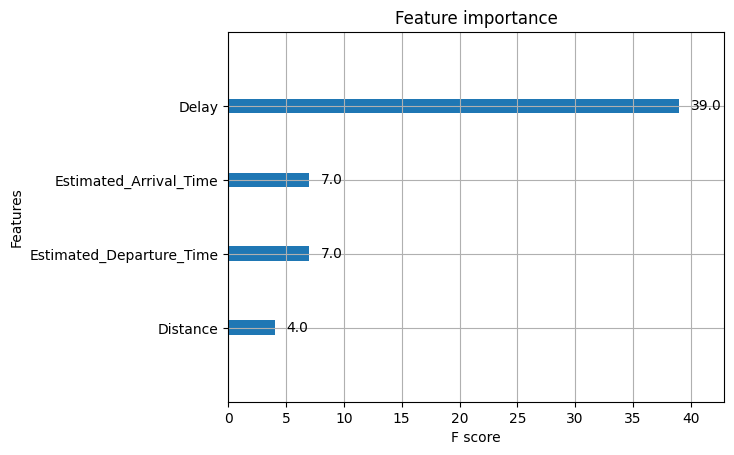

In [ ]:
plot_importance(model)
plt.show()

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 31.2 MB/s eta 0:00:00


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


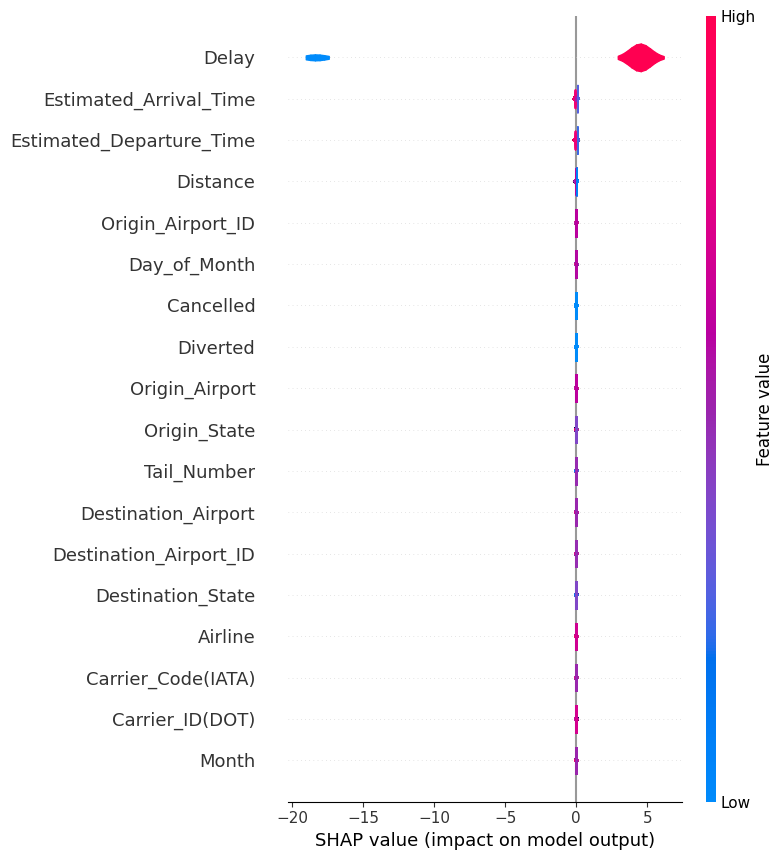

CPU times: user 40.7 s, sys: 3.13 s, total: 43.8 s
Wall time: 52.2 s


In [ ]:
%%time
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

shap.summary_plot(shap_values, features, plot_type='violin')

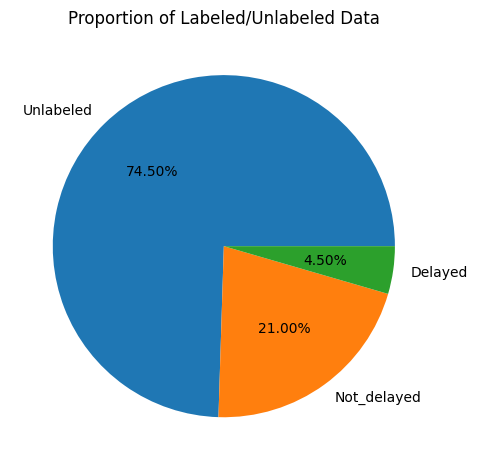

In [ ]:
unlabeled_delay_value = train_df.Delay.isnull().sum()

not_delay_value = train_df.loc[train_df.Delay == 'Not_Delayed'].shape[0]
delay_value = train_df.loc[train_df.Delay == 'Delayed'].shape[0]

labels = ['Unlabeled', 'Not_delayed', 'Delayed']
sizes = [unlabeled_delay_value, not_delay_value, delay_value]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.2f%%')
ax.set_title('Proportion of Labeled/Unlabeled Data')
plt.tight_layout()

In [ ]:
%%time

# Numeric feature only
drop_columns = ['ID', 'Origin_State', 'Destination_State', 'Airline', 'Carrier_Code(IATA)', 'Carrier_ID(DOT)', 'Origin_Airport', 'Destination_Airport', 'Tail_Number', 'Delay']
train_feature = train_df.drop(drop_columns, axis=1)

imputer = IterativeImputer(random_state=42)
imputed_feature = imputer.fit_transform(train_feature)

imputed_feature = pd.DataFrame(imputed_feature, columns=train_feature.columns) # imputed features

CPU times: user 13.6 s, sys: 9.42 s, total: 23 s
Wall time: 18.8 s


In [ ]:
imputed_feature.head(3)

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance
0,4.0,15.0,1333.469563,1486.207808,0.0,0.0,13851.0,12191.0,419.0
1,8.0,15.0,740.000000,1024.000000,0.0,0.0,13930.0,14869.0,1250.0
2,9.0,6.0,1610.000000,1805.000000,0.0,0.0,11057.0,12953.0,544.0


In [ ]:
imputed_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Month                     1000000 non-null  float64
 1   Day_of_Month              1000000 non-null  float64
 2   Estimated_Departure_Time  1000000 non-null  float64
 3   Estimated_Arrival_Time    1000000 non-null  float64
 4   Cancelled                 1000000 non-null  float64
 5   Diverted                  1000000 non-null  float64
 6   Origin_Airport_ID         1000000 non-null  float64
 7   Destination_Airport_ID    1000000 non-null  float64
 8   Distance                  1000000 non-null  float64
dtypes: float64(9)
memory usage: 68.7 MB


## Preparing Train Data


In [ ]:
target_df = [train_df[data] for data in ['Origin_Airport', 'Destination_Airport', 'Tail_Number', 'Delay']]
target_df.insert(0, imputed_feature)
final_df = pd.concat(target_df, axis=1)

In [ ]:
final_df.head(10)

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Origin_Airport,Destination_Airport,Tail_Number,Delay
0,4.0,15.0,1333.469563,1486.207808,0.0,0.0,13851.0,12191.0,419.0,OKC,HOU,N7858A,NaN
1,8.0,15.0,740.000000,1024.000000,0.0,0.0,13930.0,14869.0,1250.0,ORD,SLC,N125SY,NaN
2,9.0,6.0,1610.000000,1805.000000,0.0,0.0,11057.0,12953.0,544.0,CLT,LGA,N103US,NaN
3,7.0,10.0,905.000000,1735.000000,0.0,0.0,12892.0,11618.0,2454.0,LAX,EWR,N595UA,NaN
4,1.0,11.0,900.000000,1019.000000,0.0,0.0,14771.0,10157.0,250.0,SFO,ACV,N161SY,NaN
5,4.0,13.0,1545.000000,1639.334379,0.0,0.0,11618.0,11278.0,199.0,EWR,DCA,N657RW,Not_Delayed
6,1.0,20.0,1742.000000,1903.000000,0.0,0.0,11618.0,10721.0,200.0,EWR,BOS,N66825,Not_Delayed
7,4.0,20.0,1815.000000,1955.000000,0.0,0.0,13930.0,13198.0,403.0,ORD,MCI,N110SY,NaN
8,6.0,13.0,1420.000000,1550.000000,0.0,0.0,10821.0,11057.0,361.0,BWI,CLT,N765SW,Not_Delayed
9,6.0,6.0,650.000000,838.000000,0.0,0.0,12992.0,12266.0,374.0,LIT,IAH,N14902,NaN


### Label Encoding in Categorical Features

In [ ]:
# Label Encoding for string data
for c in ['Origin_Airport', 'Destination_Airport', 'Tail_Number']:
    le = LabelEncoder()
    le.fit(final_df[c])
    final_df[c] = le.transform(final_df[c])

In [ ]:
print(f'max_value of Origin_Airport: {final_df.Origin_Airport.max()}')
print(f'max_value of Destination_Airport: {final_df.Destination_Airport.max()}')
print(f'max_value of Tail_Number: {final_df.Tail_Number.max()}')

max_value of Origin_Airport: 373
max_value of Destination_Airport: 374
max_value of Tail_Number: 6429


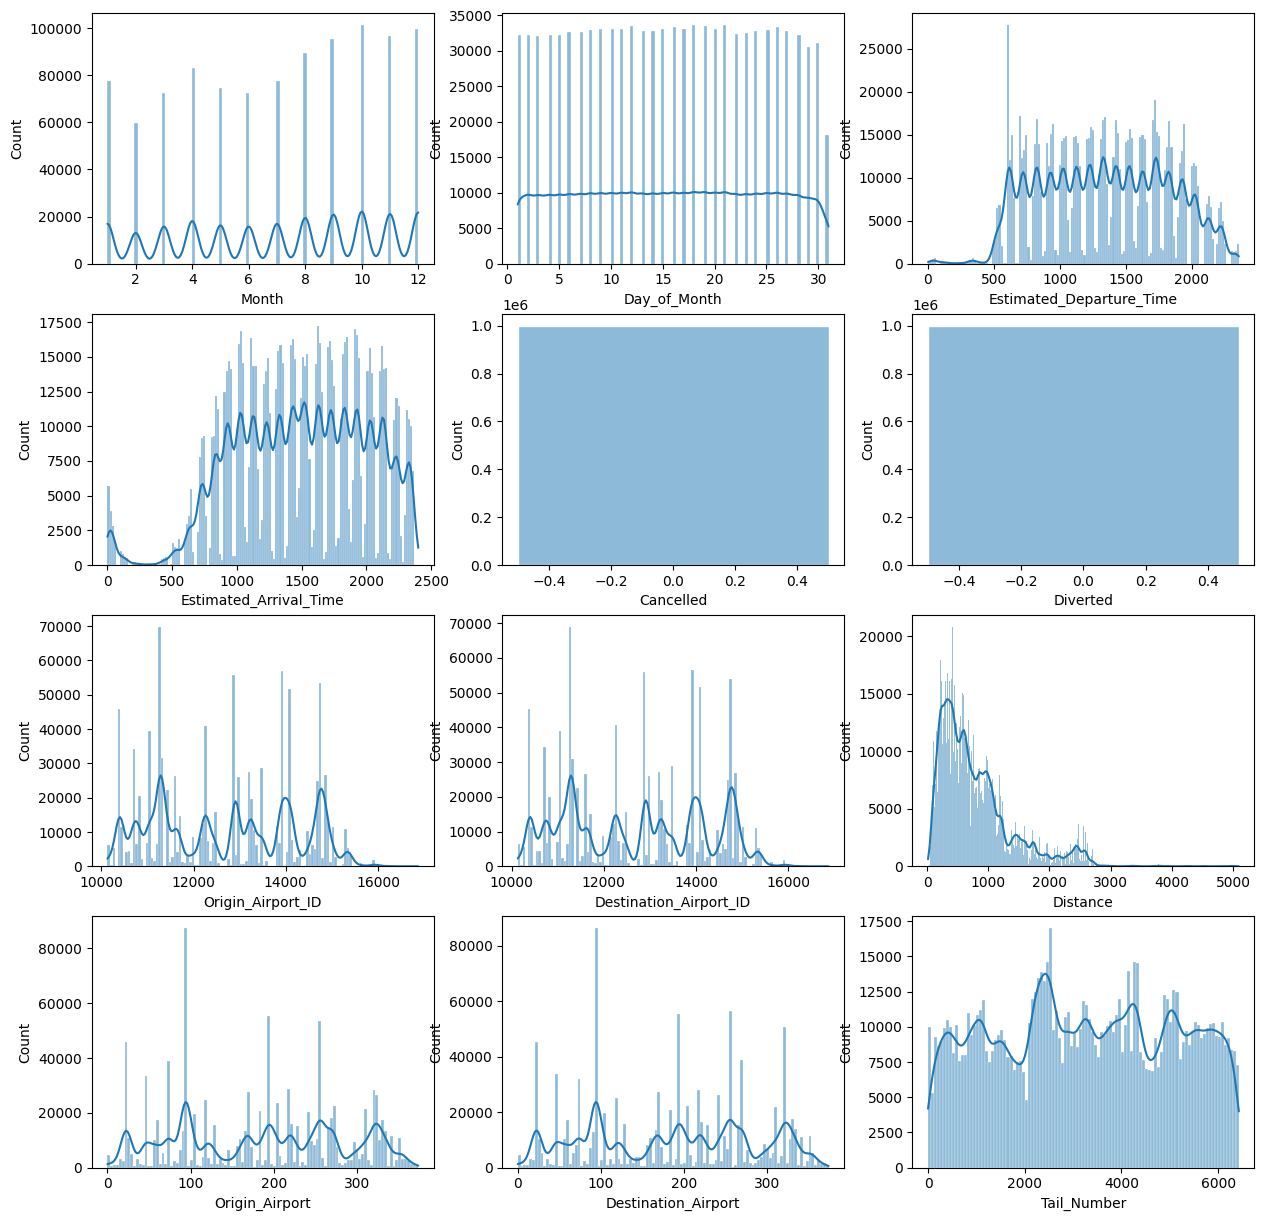

CPU times: user 46.2 s, sys: 1.36 s, total: 47.6 s
Wall time: 53.8 s


In [ ]:
%%time

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
sns.set_theme(style='whitegrid')

col_name = final_df.columns.values.tolist()

index = 0
for row in range(4):
    for col in range(3):
        sns.histplot(data=final_df, x=col_name[index], kde=True, ax=axes[row, col])
        index += 1

plt.show()

### Z-score normalization

In [ ]:
pd.set_option('mode.chained_assignment', None) # Ignore SettingWithCopyWarning

# z-score normalization
aimed_col = ['Month', 'Day_of_Month', 'Estimated_Departure_Time', 'Estimated_Arrival_Time', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Distance', 'Origin_Airport', 'Destination_Airport', 'Tail_Number']
for col in aimed_col:
    final_df[col] = (final_df[col] - final_df[col].mean()) / final_df[col].std()

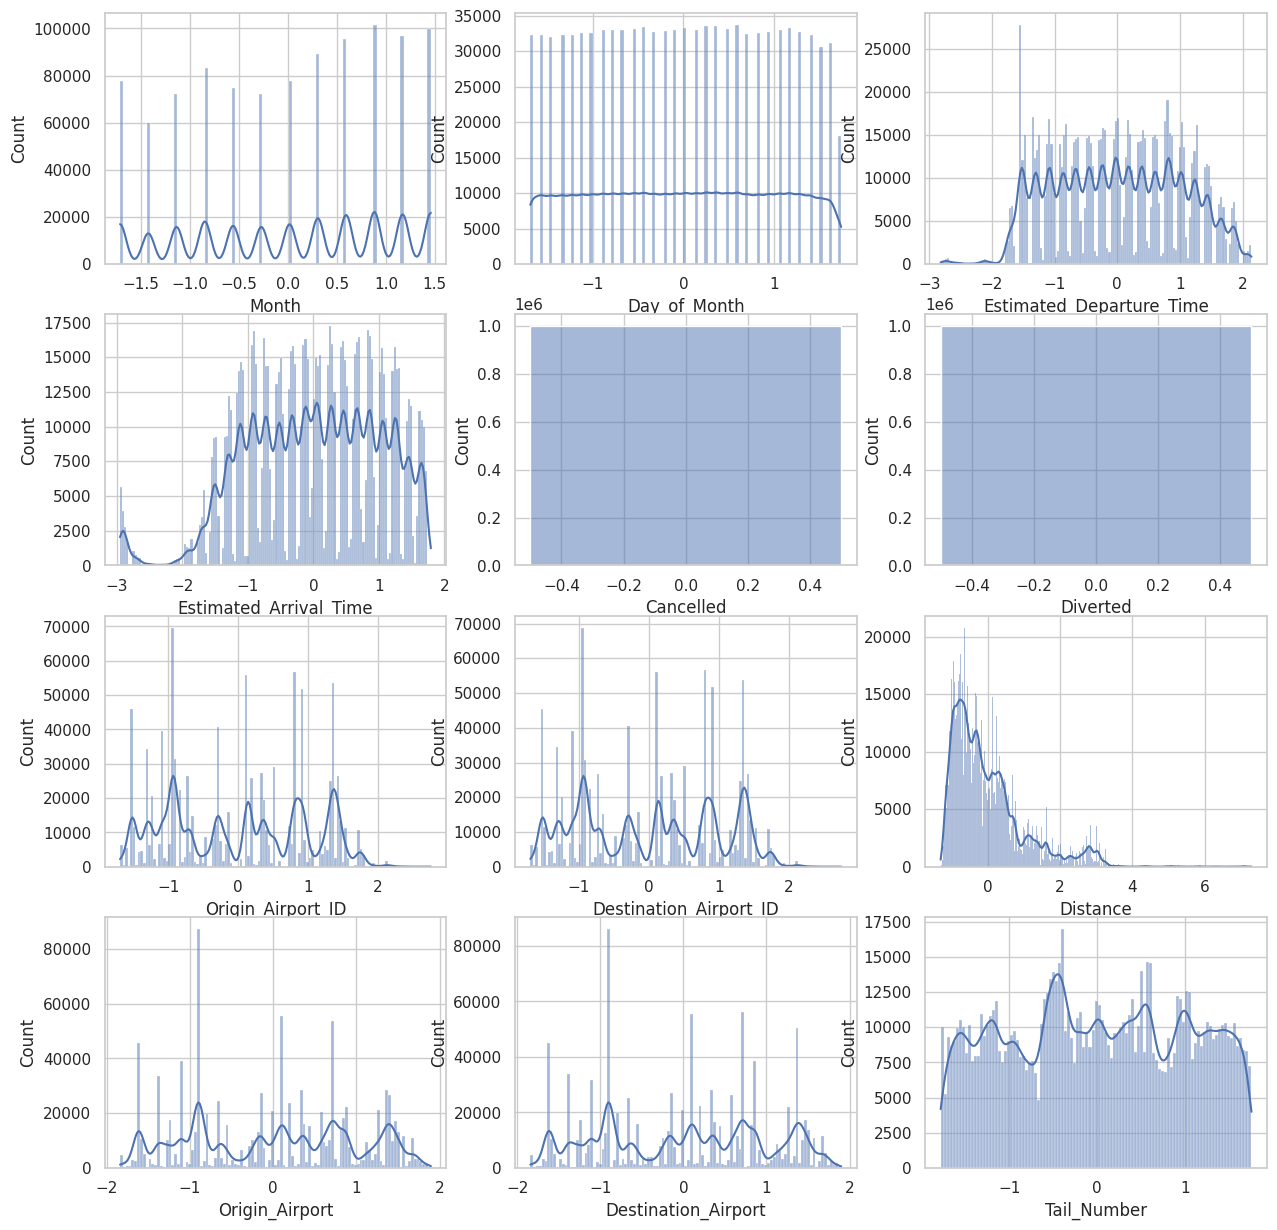

CPU times: user 42.7 s, sys: 1.6 s, total: 44.3 s
Wall time: 44.4 s


In [ ]:
%%time

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
sns.set_theme(style='whitegrid')

col_name = final_df.columns.values.tolist()

index = 0
for row in range(4):
    for col in range(3):
        sns.histplot(data=final_df, x=col_name[index], kde=True, ax=axes[row, col])
        index += 1

plt.show()

In [ ]:
final_df.head(3)

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Origin_Airport,Destination_Airport,Tail_Number,Delay
0,-0.850585,-0.087276,-0.015940,-0.013746,0.0,0.0,0.762223,-0.337124,-0.617949,0.682733,-0.251234,0.598670,NaN
1,0.304648,-0.087276,-1.263951,-0.928092,0.0,0.0,0.814371,1.430285,0.788641,0.722746,1.469016,-1.610785,NaN
2,0.593456,-1.114261,0.565577,0.616893,0.0,0.0,-1.082076,0.165776,-0.406368,-1.097855,0.198831,-1.704476,NaN


In [ ]:
ul_df = final_df.loc[final_df.Delay.isnull()].drop(['Delay'], axis=1)
l_df = final_df.loc[final_df.Delay.notnull()]

le = LabelEncoder()
le.fit(l_df['Delay'])
l_df['Delay'] = le.transform(l_df['Delay'])

l_x = torch.tensor(l_df.iloc[:, :-1].values).type(torch.float32).to('cuda:0')
l_y = torch.tensor(l_df['Delay'].values).type(torch.float32).to('cuda:0')
u_x = torch.tensor(ul_df.values).type(torch.float32).to('cuda:0')

print(le.classes_)

['Delayed' 'Not_Delayed']


In [ ]:
print(f'{l_x.dtype} / {l_y.dtype} / {u_x.dtype}')

torch.float32 / torch.float32 / torch.float32


In [ ]:
class BaseModel(nn.Module):
    def __init__(self, d_columns, d_model=128, dropout=0.2):
        super().__init__()

        self.ff_activation = nn.ReLU()
        self.ff_batchnorm = nn.BatchNorm1d(d_model)

        self.ff_1 = nn.Linear(d_columns, d_model)
        self.ff_2 = nn.Linear(d_model, d_model)
        self.ff_3 = nn.Linear(d_model, d_model)
        self.ff_4 = nn.Linear(d_model, d_model)
        self.ff_5 = nn.Linear(d_model, d_model)

        self.classification = nn.Sequential(
            nn.Linear(d_model, int(d_model/2)),
            nn.BatchNorm1d(int(d_model/2)),
            nn.Dropout(p=dropout),
            nn.GELU(),
            nn.Linear(int(d_model/2), int(d_model/4)),
            nn.BatchNorm1d(int(d_model/4)),
            nn.Dropout(p=dropout),
            nn.GELU(),
            nn.Linear(int(d_model/4), 1), # for binary classification
        )

    def forward(self, x):
        x1 = self.ff_1(x)
        x1 = self.ff_batchnorm(x1)
        x1 = self.ff_activation(x1)

        x2 = self.ff_2(x1)
        x2 = self.ff_batchnorm(x2)
        x2 = self.ff_activation(x2)

        x3 = self.ff_3(torch.add(x1,x2))
        x3 = self.ff_batchnorm(x3)
        x3 = self.ff_activation(x3)

        x4 = self.ff_4(x3)
        x4 = self.ff_batchnorm(x4)
        x4 = self.ff_activation(x4)

        x5 = self.ff_5(torch.add(x3,x4))
        x5 = self.ff_batchnorm(x5)
        x5 = self.ff_activation(x5)

        logits = self.classification(x5)
        return F.sigmoid(logits).view(-1)

class CustomLoss(nn.Module):
    def __init__(self, xi):
        super(CustomLoss, self).__init__()
        self.xi = xi

    def forward(self, output, target):
        return torch.mean(-1.0*((1-self.xi)*target*torch.log(output) + self.xi*(1-target)*torch.log(1-output)))

In [ ]:
teacher = BaseModel(d_columns=12).to('cuda:0')
student = BaseModel(d_columns=12).to('cuda:0')

t_optimizer = optim.SGD(teacher.parameters(),lr=0.0001, momentum=0.9)
s_optimizer = optim.SGD(student.parameters(),lr=0.0001, momentum=0.9)

criterion = CustomLoss(xi=0.725)
best_loss = np.inf
patient = 0

early_stop_epoch = 0
tl_loss, sl_loss = [], []
for epochs in tqdm(range(5000)):
    teacher.train()
    student.train()

    t_optimizer.zero_grad()
    s_optimizer.zero_grad()

    s_l_pred = student(l_x)
    s_l_loss = criterion(s_l_pred, l_y)

    sl_loss.append(s_l_loss.item())

    t_u_pred = teacher(u_x)
    pseudo_y = (t_u_pred >= torch.FloatTensor([0.5]).to('cuda:0')).type(torch.float32)

    s_u_pred = student(u_x)
    s_u_loss = criterion(s_u_pred, pseudo_y)
    s_u_loss.backward()
    s_optimizer.step()

    s_l_pred_new = student(l_x)
    s_l_loss_new = criterion(s_l_pred_new, l_y)
    change = s_l_loss_new - s_l_loss

    t_l_pred = teacher(l_x)
    t_l_loss = criterion(t_l_pred, l_y)

    tl_loss.append(t_l_loss.item())

    t_mpl_loss = change * criterion(t_u_pred, pseudo_y)

    (t_l_loss + t_mpl_loss).backward()
    t_optimizer.step()

#    if epochs+1 >= 250 and best_loss > s_l_loss.item():
#        best_loss = s_l_loss.item()
#        patient = 0
#    elif epochs+1 >= 250 and best_loss <= s_l_loss.item():
#        patient += 1
#
#    if patient == 20:
#        early_stop_epoch = epochs + 1
#
#        torch.save(teacher.state_dict(), root_path+'/models/teacher/es_ratio_loss_teacher_state_dict.pt')
#        torch.save(student.state_dict(), root_path+'/models/student/es_ratio_loss_student_state_dict.pt')

  0%|          | 0/5000 [00:00<?, ?it/s]

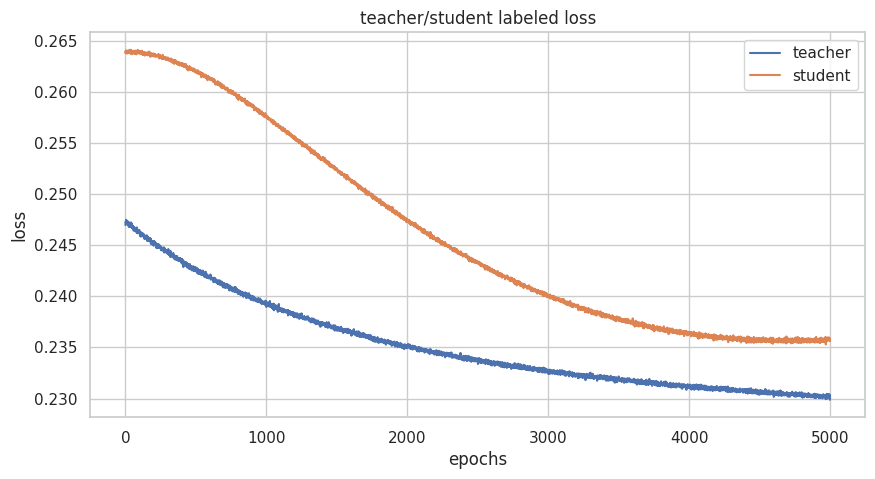

In [ ]:
x = np.linspace(0, 5000, 5000)

plt.figure(figsize=(10, 5))
plt.plot(x, tl_loss, label='teacher')
plt.plot(x, sl_loss, label='student')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('teacher/student labeled loss')
if early_stop_epoch:
    plt.axvline(early_stop_epoch, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.legend()
plt.show()

In [ ]:
torch.save(teacher.state_dict(), root_path+'/models/teacher/725_ratio_loss_many_epochs_teacher_state_dict.pt')
torch.save(student.state_dict(), root_path+'/models/student/725_ratio_loss_many_epochs_student_state_dict.pt')

In [ ]:
root_path = '/content/drive/MyDrive/flight project'
student_trained = BaseModel(d_columns=12).cuda()
student_trained.load_state_dict(torch.load(root_path+'/models/student/725_ratio_loss_many_epochs_student_state_dict.pt'))
student_trained.eval()

BaseModel(
  (ff_activation): ReLU()
  (ff_batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ff_1): Linear(in_features=12, out_features=128, bias=True)
  (ff_2): Linear(in_features=128, out_features=128, bias=True)
  (ff_3): Linear(in_features=128, out_features=128, bias=True)
  (ff_4): Linear(in_features=128, out_features=128, bias=True)
  (ff_5): Linear(in_features=128, out_features=128, bias=True)
  (classification): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): GELU(approximate='none')
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): GELU(approximate='none')
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

## Preparing Test Data

In [ ]:
test_df = pd.read_csv(root_path+'/test.csv')

drop_columns = ['ID', 'Origin_State', 'Destination_State', 'Airline', 'Carrier_Code(IATA)', 'Carrier_ID(DOT)', 'Origin_Airport', 'Destination_Airport', 'Tail_Number']
train_feature = test_df.drop(drop_columns, axis=1)

imputer = IterativeImputer(random_state=42)
imputed_feature = imputer.fit_transform(train_feature)

imputed_feature = pd.DataFrame(imputed_feature, columns=train_feature.columns) # imputed features

target_df = [test_df[data] for data in ['Origin_Airport', 'Destination_Airport', 'Tail_Number']]
target_df.insert(0, imputed_feature)
final_df = pd.concat(target_df, axis=1)

# Label Encoding for string data
for c in ['Origin_Airport', 'Destination_Airport', 'Tail_Number']:
    le = LabelEncoder()
    le.fit(final_df[c])
    final_df[c] = le.transform(final_df[c])

pd.set_option('mode.chained_assignment', None) # Ignore SettingWithCopyWarning

# z-score normalization
aimed_col = ['Month', 'Day_of_Month', 'Estimated_Departure_Time', 'Estimated_Arrival_Time', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Distance', 'Origin_Airport', 'Destination_Airport', 'Tail_Number']
for col in aimed_col:
    final_df[col] = (final_df[col] - final_df[col].mean()) / final_df[col].std()

test_x = torch.tensor(final_df.values).type(torch.float32).cuda()

In [ ]:
final_df.head(3)

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Origin_Airport,Destination_Airport,Tail_Number
0,1.526254,0.044898,-0.468430,-0.342468,0.0,0.0,-0.279590,1.311013,-1.017307,-0.139317,1.264011,0.638707
1,0.663277,-0.414529,0.260294,0.376967,0.0,0.0,-0.708928,-1.521945,-0.083842,-0.636777,-1.622434,-0.708686
2,-1.062675,-1.103671,0.472132,0.767983,0.0,0.0,0.822908,0.167518,-0.105707,0.726263,0.199012,-0.591000


In [ ]:
pred_test = student_trained(test_x)

In [ ]:
proba_ndelayed = pred_test.cpu().data.numpy().reshape(-1,1)
proba_delayed = 1 - proba_ndelayed

print(proba_ndelayed.shape)

(1000000, 1)


In [ ]:
final_pred = np.concatenate((proba_ndelayed, proba_delayed), axis=1)
print(final_pred.shape)

(1000000, 2)


In [ ]:
sample_submission = pd.read_csv(root_path+'/sample_submission.csv', index_col = 0)
submission = pd.DataFrame(data=final_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv(root_path+'/missing_725_submission.csv', index=True)